# 20mer Regression analysis

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import cycle
import pickle

import sklearn.manifold
from sklearn.metrics import roc_curve, auc, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVR, SVR
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import RFECV as yellowRFECV
from sklearn.kernel_ridge import KernelRidge

from math import log10, pow, log,sqrt
from statistics import mean
import scipy.stats as stats

In [41]:
#Load data
rownames = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input20mer_7514.csv", "rb"),delimiter=',', dtype='str')[0,:]
names = np.asarray([_ for _ in rownames])
df = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input20mer_7514.csv", "rb"),delimiter=',', usecols=range(1,rownames.shape[0]), dtype='float', skiprows=1)
sgRNA_seq = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input20mer_7514.csv", "rb"),delimiter=',', usecols=0, dtype='str', skiprows=1)

#sort by sequence (not by activity/efficiency which is the response variable)
indx = sgRNA_seq.argsort()
df = df[indx,:]

#Standard scale non binary features
sc = StandardScaler()
df[:,1:26] = sc.fit_transform(df[:,1:26])

#Save standardized dataset
pd.DataFrame(np.column_stack((sgRNA_seq, df)), columns=names).to_csv("/home/pierre/Desktop/Position_Matrix/ML_REG_input20mer_7514-scaled.csv",index=False)

#Number of cpus to use for multithreading
n_cpu = 2

### RFECV

In [3]:
#Recursive Feature Elimination with Cross-Validation to remove the irrelevant features

modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l1 Linear Regression",
    "l1/l2 Linear Regression",
    "l2 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]

model = [
    LinearRegression(n_jobs=n_cpu),
    LinearSVR(random_state=0),
    Lasso(random_state=0),
    ElasticNet(random_state=0),
    Ridge(random_state=0),
    GradientBoostingRegressor(random_state=0),
    RandomForestRegressor(random_state=0)
]

rfecv = dict()
models=dict()
datasets=dict()
supports = dict()
i=0
for name, clf in zip(modelnames, model):    
    model = RFECV(estimator=clf, 
                    cv=KFold(n_splits=10, random_state=0), 
                    scoring='r2', n_jobs=n_cpu)
    rfecv[i] = model
    model.fit(df[:,1:], df[:,0])

    X_new = model.transform(df[:,1:])
    sup = model.get_support(True)
    
    #Insert Column names
    X_new = pd.DataFrame(X_new, columns=names[2:][sup])

    print(X_new.shape)
    
    models[i] = model
    datasets[i] = X_new
    supports[i] = sup
    
    i+=1

(7514, 31)
(7514, 219)
(7514, 409)
(7514, 409)
(7514, 326)
(7514, 102)
(7514, 283)


TypeError: 'AxesSubplot' object is not subscriptable

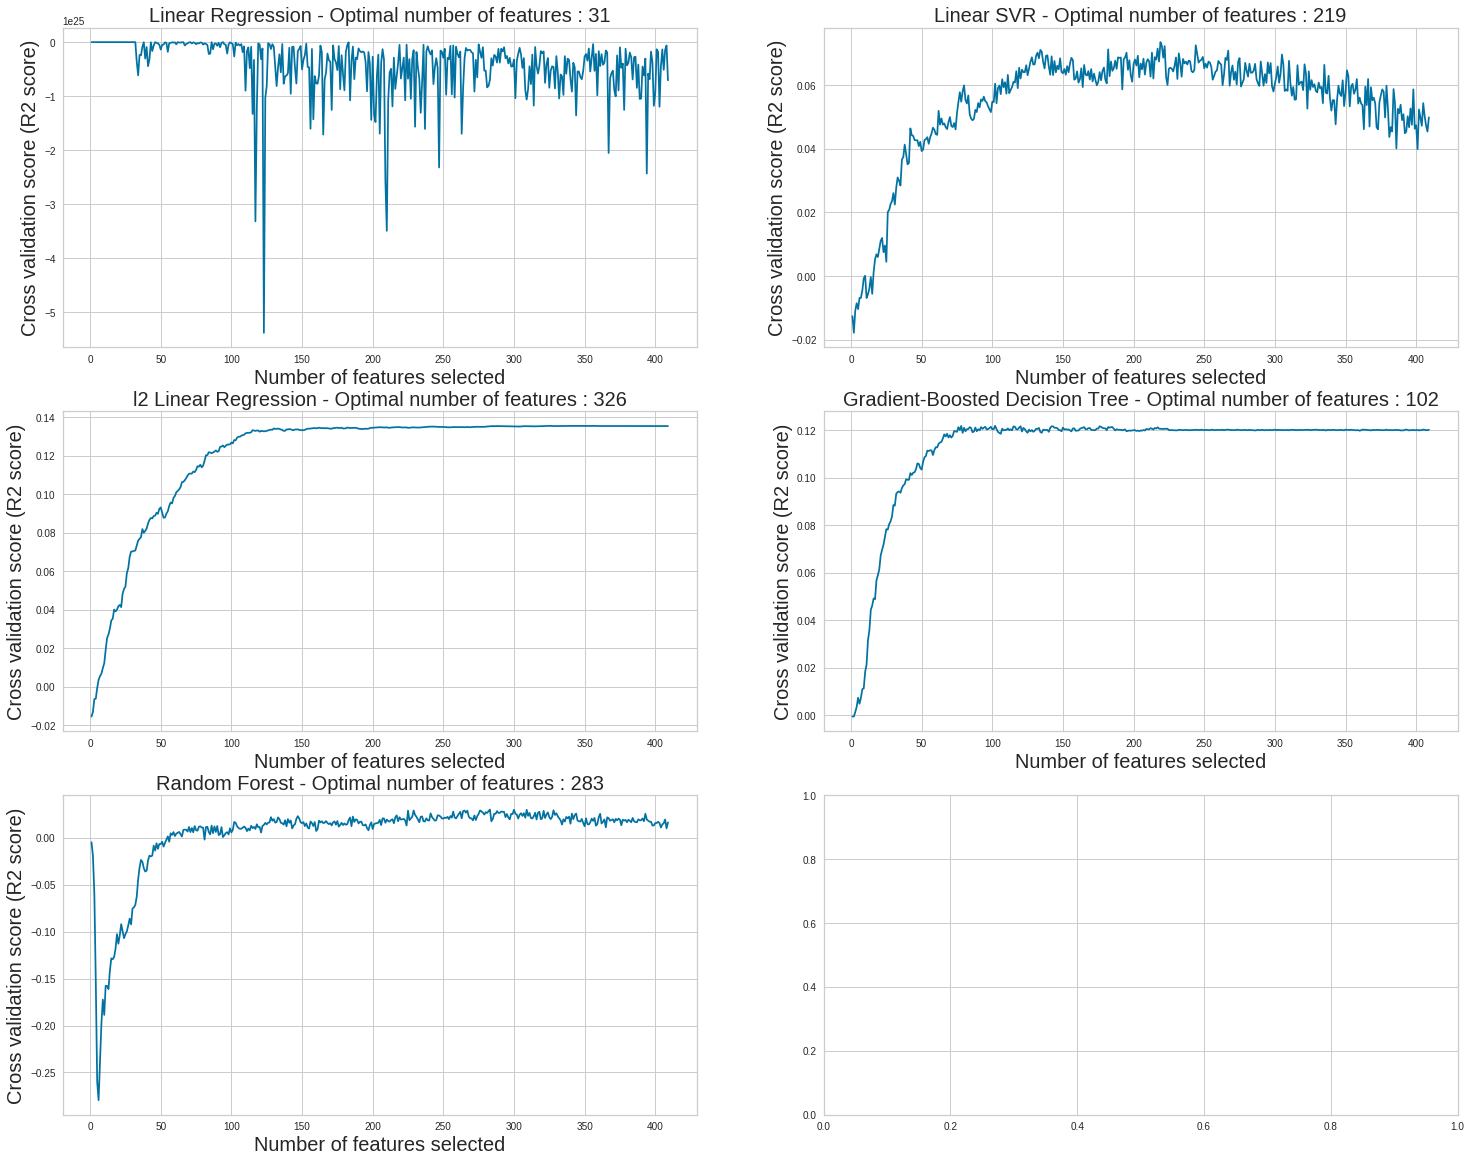

In [16]:
# RFECV to plot
modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l2 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]
n_groups = 5

# create plot
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(25,20))
plt.figure()

index = np.arange(n_groups)

for ax, i in zip(axes.flatten(),range(n_groups)):
    rfecv_model = rfecv[i]
    X_newL1 = datasets[i]

    ax.set_xlabel("Number of features selected", fontsize=20)
    ax.set_ylabel("Cross validation score (R2 score)", fontsize=20)
    ax.set_title("%s - Optimal number of features : %d" % (modelnames[i], X_newL1.shape[1]), fontsize=20)
    ax.plot(range(1, len(rfecv_model.grid_scores_) + 1), rfecv_model.grid_scores_)
    
plt.show()

In [3]:
data = {
    'rfecv': rfecv,
    'datasets': datasets,
    'supports': supports
}

pickle_out = open("20mer_RFECV.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

NameError: name 'rfecv' is not defined

In [7]:
# Uncomment to load the frecv and datasets
pickle_in = open("20mer_RFECV.pickle","rb")
p_load = pickle.load(pickle_in)

rfecv = p_load['rfecv']
datasets = p_load['datasets']
supports = p_load['supports']

## Hyperparameter Optimization & Performance Evaluation

In [6]:
models = [LinearRegression(),
          LinearSVR(),
          Ridge(),
          GradientBoostingRegressor(),
          RandomForestRegressor()
        ]

# set up params

tuned_parameters = [{},
                    {'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
                     'epsilon': [0,0.001,0.01,0.1,1],
                     'C': [0.001,0.01,0.1,1,10,100,1000]},
                    {'alpha': np.logspace(log10(10e-5),log10(1.5e5),100)},
                    {'n_estimators':[50,100,150,200],
                    'max_depth':[2,4,6,8,10],
                    'min_samples_split':[2,4],
                    'min_samples_leaf':[1,2],
                    'max_features':['auto','sqrt','log2']},
                    {'n_estimators':[50,100,150,200],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']}
                   ]
grid = dict()

for i in datasets :
    print(datasets[i].shape)
    grid[i] = dict()
    for j in range(len(models)):
        
        print(str(models[j]))
        print(str(tuned_parameters[j]))
        print()
        
        #Inner CV for parameter Optimization
        grid[i][j] = GridSearchCV(models[j], 
                                  tuned_parameters[j], 
                                  cv=KFold(n_splits=10, shuffle=True, random_state=i+j), 
                                  scoring='r2',n_jobs=n_cpu).fit(datasets[i], df[:,0])


(7514, 31)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
{}

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
{'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'epsilon': [0, 0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

In [ ]:
r2 = dict()
r2_adj = dict()
RMSE = dict()

for i in grid :
    print(datasets[i].shape)
    n =(datasets[i].shape[0])
    k =(datasets[i].shape[1])
    r2[i] = dict()
    r2_adj[i] = dict()
    RMSE[i] = dict()
    for j in range(len(grid[i])):
        print(str(grid[i][j]))
        
        scoreR2 = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='r2', n_jobs=n_cpu))
        print('r2 = ',scoreR2)
        
        scoreR2_adj =1-(1-scoreR2)*(n-1)/(n-(k+1))
        print('r2_adj = ',scoreR2_adj)
        
        scoreRMSE = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='neg_mean_squared_error', n_jobs=n_cpu))
        print('RMSE = ',sqrt(abs(scoreRMSE)))
        
        r2[i][j] = scoreR2
        r2_adj[i][j] = scoreR2_adj
        RMSE[i][j] = sqrt(abs(scoreRMSE))
        
        print('_____________')

(7514, 31)
GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=2, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)
r2 =  0.07259837709687873
r2_adj =  0.06875589509875035
RMSE =  0.27783631568072786
_____________
GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'epsilon': [0, 0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=Tru

In [ ]:
data = {
    'grid': grid,
    'r2': r2,
    'r2_adj': r2_adj,
    'RMSE': RMSE
}

pickle_out = open("20mer_GRID&Perf.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [6]:
pickle_in = open("20mer_GRID&Perf.pickle","rb")
p_load = pickle.load(pickle_in)

grid = p_load['grid']
r2 = p_load['r2']
r2_adj = p_load['r2_adj']
RMSE = p_load['RMSE']

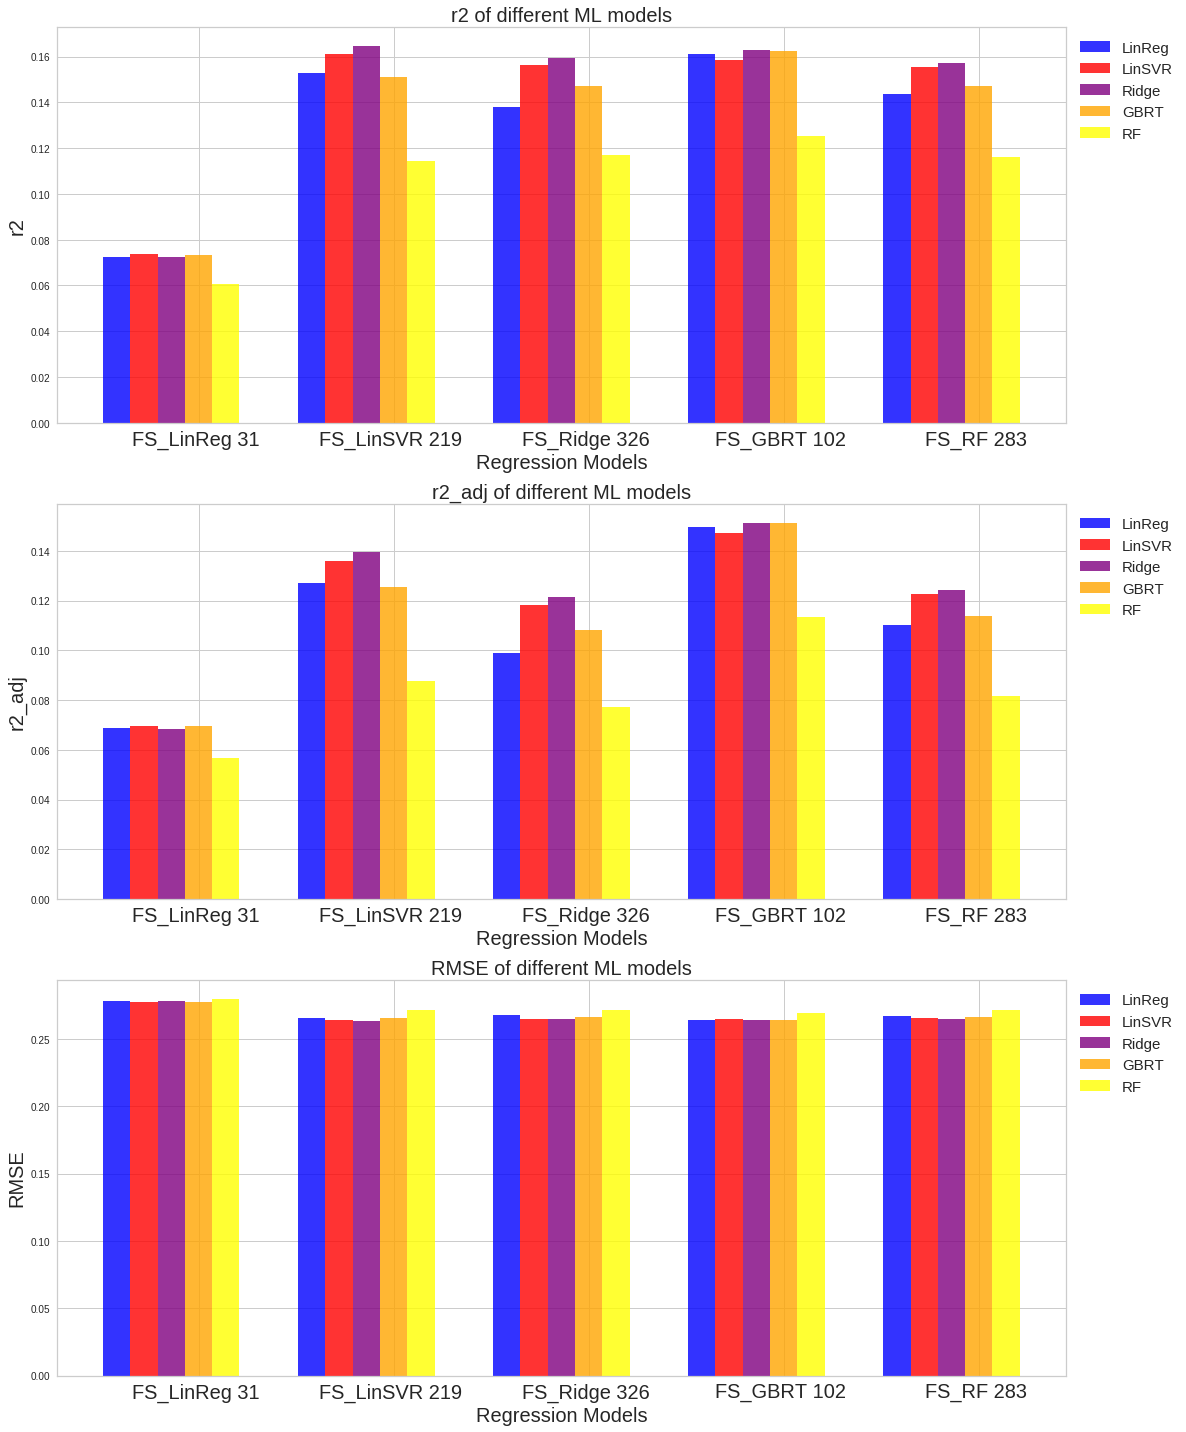

In [5]:
# data to plot
n_groups = 5
metrics = {'r2':r2, 'r2_adj':r2_adj, 'RMSE':RMSE}

# create plot
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,20))

index = np.arange(n_groups)
bar_width = 0.14
opacity = 0.8

i=0
for ax, v in zip(axes.flatten(),metrics.keys()):
    FS_LinReg = list()
    FS_LinSVR = list()
    FS_Ridge = list()
    FS_GBRT = list()
    FS_RF = list()
    for i in range(len(metrics[v])):
        FS_LinReg.append(metrics[v][i][0])
        FS_LinSVR.append(metrics[v][i][1])
        FS_Ridge.append(metrics[v][i][2])
        FS_GBRT.append(metrics[v][i][3])
        FS_RF.append(metrics[v][i][4])
    FS_LinReg = tuple(FS_LinReg)
    FS_LinSVR = tuple(FS_LinSVR)
    FS_Ridge = tuple(FS_Ridge)
    FS_GBRT = tuple(FS_GBRT)
    FS_RF = tuple(FS_RF)

    rects1 = ax.bar(index, FS_LinReg, bar_width, align = 'center',
                     alpha=opacity,
                     color='blue',
                     label='LinReg')

    rects2 = ax.bar(index + bar_width, FS_LinSVR, bar_width, align = 'center',
                     alpha=opacity,
                     color='red',
                     label='LinSVR')

    rects5 = ax.bar(index + bar_width*2, FS_Ridge, bar_width, align = 'center',
                     alpha=opacity,
                     color='purple',
                     label='Ridge')

    rects6 = ax.bar(index + bar_width*3, FS_GBRT, bar_width, align = 'center',
                     alpha=opacity,
                     color='orange',
                     label='GBRT')

    rects7 = ax.bar(index + bar_width*4, FS_RF, bar_width, align = 'center',
                     alpha=opacity,
                     color='yellow',
                     label='RF')

    ax.set_xlabel('Regression Models',fontsize=20)
    ax.set_ylabel(v,fontsize=20)
    ax.set_title('%s of different ML models' % v,fontsize=20)
    ax.set_xticks(index + bar_width*3)
    ax.set_xticklabels(['FS_LinReg %i ' % datasets[0].shape[1], 
                        'FS_LinSVR %i ' % datasets[1].shape[1], 
                        'FS_Ridge %i ' % datasets[2].shape[1], 
                        'FS_GBRT %i ' % datasets[3].shape[1],
                        'FS_RF %i ' % datasets[4].shape[1]], fontsize=20)
    ax.legend(fontsize=15,loc='upper right', bbox_to_anchor=(1.12, 1), ncol=1)
    i+=1

plt.tight_layout()
plt.show()

In [10]:
data = {
    'model': grid[3][2].best_estimator_,
    'df_indexes': supports[3]
}

pickle_out = open("20mer_102FS_Ridge_RegModel.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [8]:
pickle_in = open("20mer_102FS_Ridge_RegModel.pickle","rb")
p_load = pickle.load(pickle_in)
Model = p_load['model']
idx = p_load['df_indexes']

# Residual plot Analysis

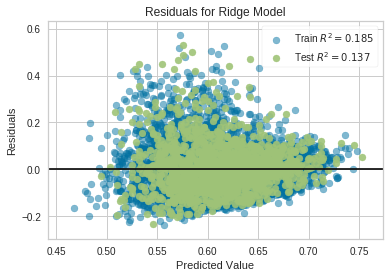

In [42]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(datasets[3], df[:,0], test_size=0.2)

model = Model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()  

## Ridge FS - GBRT

In [36]:
Model.intercept_

0.6011372457960822

In [24]:
df_importance = pd.DataFrame(grid[3][3].best_estimator_.feature_importances_, datasets[3].columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(df_importance)

                0
Tm20mer  0.034016
nbA      0.026325
nbG      0.025548
nbT      0.027790
nbAC     0.014191
nbAG     0.018980
nbCC     0.020610
nbCG     0.024030
nbCT     0.015228
nbGC     0.016132
nbGG     0.023558
nbGT     0.019570
nbTA     0.019498
nbTC     0.019571
nbTT     0.020399
A2       0.006715
A5       0.005072
A8       0.007756
C2       0.014430
C4       0.013257
C5       0.004344
C8       0.006157
C9       0.010360
C11      0.008664
C13      0.004910
C15      0.005213
C18      0.010556
C20      0.011870
G5       0.008633
G6       0.004878
G8       0.006300
G9       0.015997
G12      0.007564
G13      0.010100
G14      0.010969
G15      0.009402
G16      0.012227
G20      0.009974
T1       0.006738
T8       0.006675
T11      0.008857
T12      0.005528
T13      0.011989
T18      0.007768
AA1      0.009296
AA15     0.007958
AA18     0.010370
AC2      0.005637
AC10     0.006084
AC15     0.003349
AC17     0.010922
AG6      0.008686
AG8      0.006690
AG11     0.006892
AG12     0

In [32]:
Tm20mer = sum(df_importance.iloc[0])
print(Tm20mer)

pos_indep_order1 = sum(df_importance.iloc[1:4][0])
print(pos_indep_order1)
pos_dep_order1 = sum(df_importance.iloc[15:44][0])
print(pos_dep_order1)

pos_indep_order2 = sum(df_importance.iloc[4:15][0])
print(pos_indep_order2)
pos_dep_order2 = sum(df_importance.iloc[44:][0])
print(pos_dep_order2)

#PAM_bounds = sum(df_importance.iloc[197:][0])
#print(PAM_bounds)

0.03401643373503039
0.07966313250817672
0.25290213358990943
0.21176791048065874
0.42165038968622476


1.0


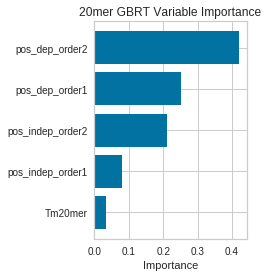

In [35]:
print(sum((Tm20mer,pos_indep_order1,pos_indep_order2,pos_dep_order1,pos_dep_order2)))

pos = np.arange(5) + .5
plt.subplot(1, 2, 2)
plt.barh(pos,(Tm20mer,pos_indep_order1,pos_indep_order2,pos_dep_order1,pos_dep_order2), align='center')
plt.yticks(pos, ('Tm20mer','pos_indep_order1','pos_indep_order2','pos_dep_order1','pos_dep_order2'))
plt.xlabel('Importance')
plt.title('20mer GBRT Variable Importance')
plt.show()

## Guide efficiency prediction performance

### Training set

In [53]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-20mer_sgRNA_7514predictions.csv", "rb"), delimiter=',', usecols=(1,2), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0.1,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0])*100)
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0])*100)
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0])*100)
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0])*100)

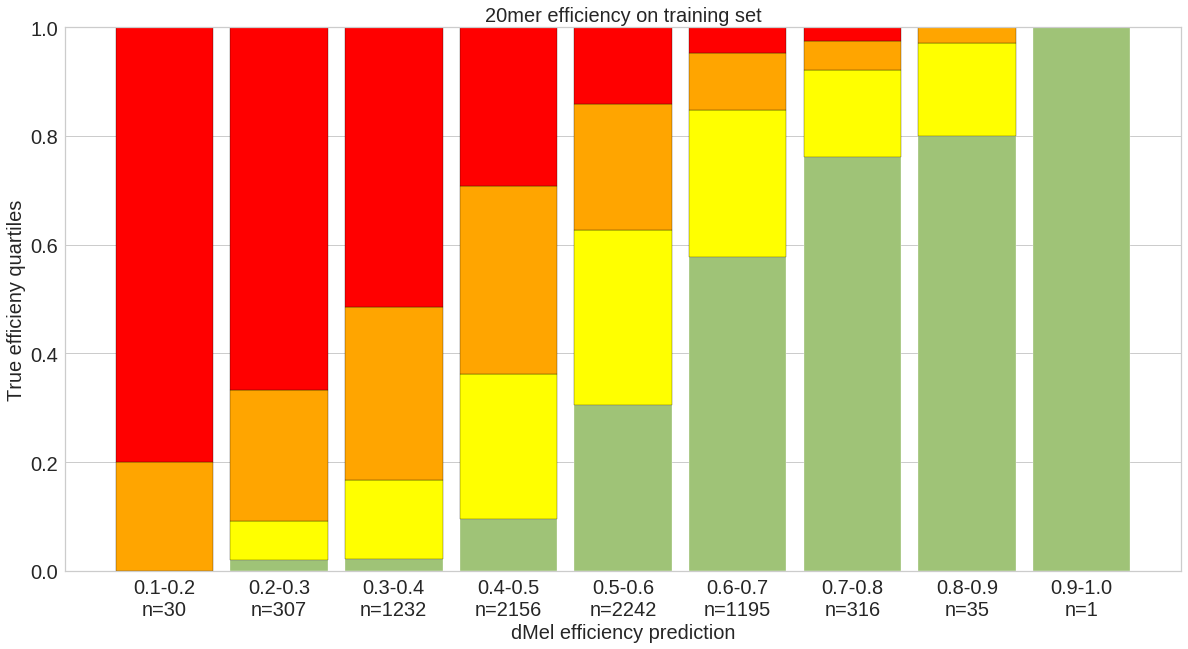

In [54]:
# Data
r = [1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j  for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.1-0.2\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[8][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='white', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("20mer efficiency on training set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()

### Testing set

In [16]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-Test_Set_Droso.csv", "rb"), delimiter=',', usecols=(4,5), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0.1,0.9,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0])*100)
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0])*100)
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0])*100)
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0])*100)

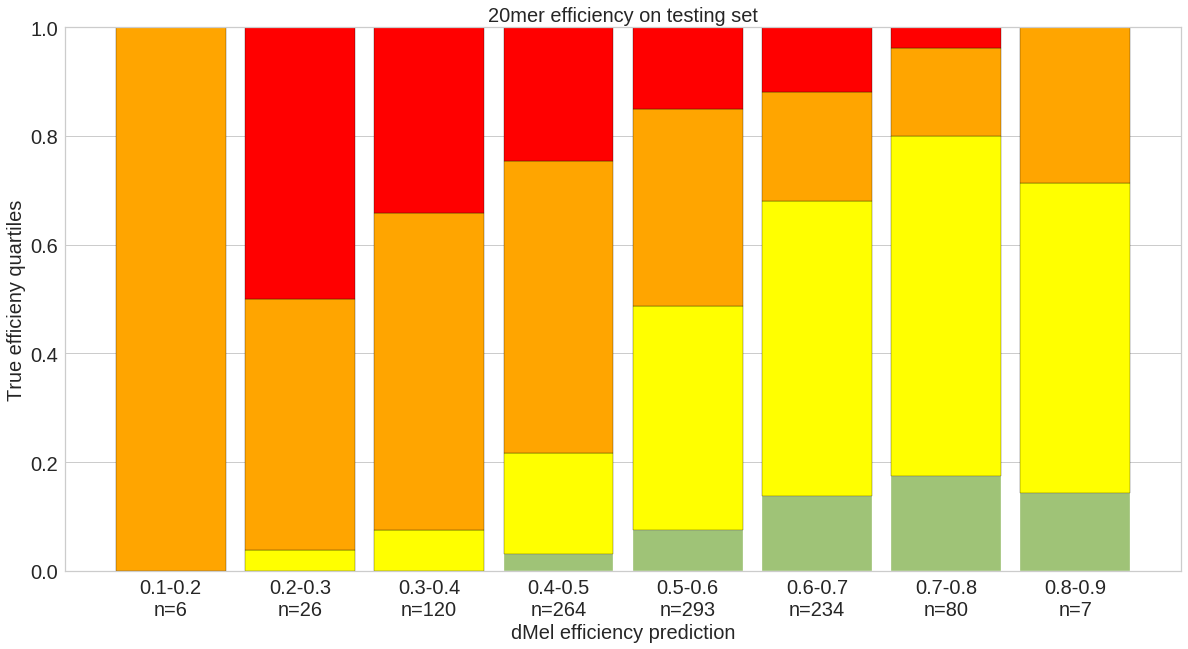

In [17]:
# Data
r = [1,2,3,4,5,6,7,8]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j  for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.1-0.2\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[7][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='white', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("20mer efficiency on testing set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()